#### Loading the necessary libraries and packages

In [1]:
# Load tensorflow
import tensorflow as tf
# Below command is to avoid the known bug which prevents computation on some GPU devices
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)
# Load preprocessing tools
from tensorflow.keras.utils import Sequence
from scipy.ndimage.filters import gaussian_filter
from PIL import Image
# Load model building blocks
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
# Load pre-trained model library
from tensorflow.keras import applications
# Load miscelaneous libraries
import numpy as np
import os
import matplotlib.pylab as plt
import gc

#### Define paths

In [3]:
train_image_path = os.path.join('/home', 'renat_sergazinov', 
                                'python-git-workspace', 'PhotoForceReconML', 'image_data', 'train')
val_image_path = os.path.join('/home', 'renat_sergazinov', 
                                'python-git-workspace', 'PhotoForceReconML', 'image_data', 'val')
train_label_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'labels', 'train')
val_label_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'labels', 'val')
models_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'models')

#### Data preprocessing and augmentation

In [4]:
# Define sorter of image names in order by image number (default is alphanumric)
def sorter(item):
    # Since highest marks first, least error = most marks
    radius = float(item[1 : item.find('_')])
    num_img = int(item[item.find('g') + 1 : item.find('j') - 1])
    return (radius, num_img)

In [5]:
# Load the train and validation sets

X_train, X_val = {}, {}
y_train, y_val = {}, {}

for k in range(5):
    i = k + 2
    X_path_train = os.path.join(train_image_path, str(i))
    X_path_val = os.path.join(val_image_path, str(i))
    X_train[i] = [os.path.join(X_path_train, name) for name in sorted(os.listdir(X_path_train), key = sorter)]
    X_val[i] = [os.path.join(X_path_val, name) for name in sorted(os.listdir(X_path_val), key = sorter)]
    y_train[i] = np.load(os.path.join(train_label_path, str(i), 'angles_inner.npy'))
    y_val[i] = np.load(os.path.join(val_label_path, str(i), 'angles_inner.npy'))

Data generators are created and defind here. Images are blurred using Gaussian blur with kernel radius = 1.The pixel values are scaled using 1/255 to be in the interval [0,1]. The images are further rescaled to 128*128 with Nearest interpolation. 

In [7]:
# Define class for data generation
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_image_paths = None, labels = None,  
                 batch_size = 32, dim = None, n_channels = 3, rescale = 1, 
                 shuffle=True, save_dir = None, preprocessing_func = None):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_image_paths = list_image_paths
        self.n_channels = n_channels
        self.rescale = rescale
        self.shuffle = shuffle
        self.save_dir = save_dir
        self.preprocessing_func = preprocessing_func
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_image_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indices = self.indices[index * self.batch_size : (index + 1) * self.batch_size]

        # Generate data
        X, y = self.__data_generation(indices)
        
        if self.save_dir is not None:
            for i in range(X.shape[0]):
                path = os.path.join(self.save_dir, 'img' + str(i) + '.jpg')
                plt.imsave(path, np.asarray(X[i, ]), vmin = 0, vmax = 1)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indices = np.arange(len(self.list_image_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __data_generation(self, indices):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        
        # Initialisation
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        list_image_paths_batch = [self.list_image_paths[k] for k in indices]
        
        # Get labels
        y = np.array([self.labels[k, :] for k in indices])
        
        # Generate data
        for i, image_path in enumerate(list_image_paths_batch):
            # Load image and transform
            image = Image.open(os.path.join(image_path))
            if self.dim is not None:
                image = image.resize(self.dim, resample = Image.NEAREST)
            image = np.array(image)[:, :, :self.n_channels]
            image = image * self.rescale
            if self.preprocessing_func is not None:
                image = self.preprocessing_func(image)
            # Store sample
            X[i,] = image

        return X, y

In [8]:
# Define gaussian blur class
class GaussBlur:
    def __init__(self, radius):
        self.radius = radius
    def blur(self, image):
        return gaussian_filter(image, sigma = self.radius)

In [9]:
# Apply data generators
gaussblur = GaussBlur(1)
params = {'batch_size': 32, 
          'dim': (128, 128), 
          'n_channels': 3, 
          'rescale': 1 / 255, 
          'shuffle': True, 
          'save_dir': None,
          'preprocessing_func': gaussblur.blur
          }

training_generator = {}
validation_generator = {}

for k in range(5):
    i = k + 2
    training_generator[i] = DataGenerator(X_train[i], y_train[i], **params)
    validation_generator[i] = DataGenerator(X_val[i], y_val[i], **params)

[0.08280181 3.22439447]
[2.34854529 5.27452324 5.91508931]
[0.52248912 1.64240832 3.41975201 5.26549078]
[0.78665405 1.68248306 3.04925513 4.20047338 5.24514917]
[0.84443451 1.63068451 2.74841345 3.85826744 4.81826606 5.49708401]


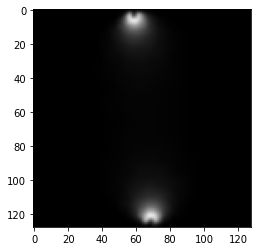

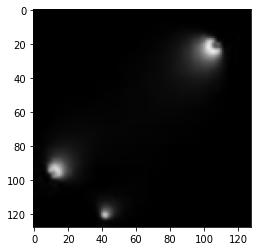

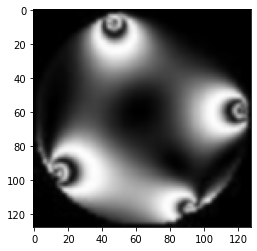

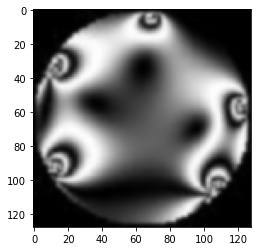

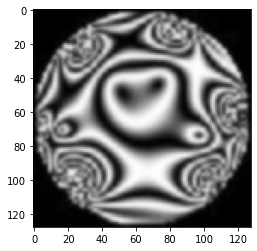

In [10]:
# Generate a sample of images for inspection

test_generator = {}
for k in range(5):
    i = k + 2
    test_generator[i] = DataGenerator(X_train[i], y_train[i], **params)
    x, y = test_generator[i].__getitem__(0)
    plt.figure()
    plt.imshow(np.asarray(x[3, ]))
    print(y[3])

#### XCEPTION Models Building

Convolutional neural networks is defined and compiled in this step.

In [11]:
base_model = {}

# Load XCEPTION model to be the base model
for k in range(5):
    i = k + 2
    base_model[i] = applications.Xception(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        input_shape=(128, 128, 3),
        include_top=False)
    base_model[i].trainable = False

In [12]:
# Define the model
model = {}
for k in range(5):
    i = k + 2
    inputs = Input(shape=(128, 128, 3))
    x = base_model[i](inputs, training = False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(i, activation='linear')(x)
    model[i] = Model(inputs, outputs)

#### XCEPTION Model Training

The model is trained using Adam optimizer. The loss is defined to be mean absolute error. Best model selection across training epochs is implemented with model checkpoint tracking the validation loss. Early stopping is set with patience of 30 epochs. 

In [13]:
for k in range(5):
    i = 2 + k
    model[i].compile(optimizer=tf.keras.optimizers.Adam(epsilon=0.1),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])

In [14]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = dict()
for k in range(5):
    i = k + 2
    model_path = os.path.join(models_path, 'xception_angles_inner_'+str(i)+'.h5')
    mc[i] = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [15]:
epochs = 200
history = {}

for k in range(5):
    i = k + 2
    print('Model for ', i, ' angles')
    history[i] = model[i].fit(training_generator[i],
                            validation_data = validation_generator[i],
                            epochs = epochs,
                            steps_per_epoch = len(training_generator[i]),
                            validation_steps = len(validation_generator[i]),
                            callbacks=[es, mc[i]]
                           )

Model for  2  angles
Epoch 1/200
500/500 [==============================] - ETA: 0s - loss: 0.8496 - mean_absolute_error: 0.8496
Epoch 00001: val_loss improved from inf to 0.41320, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_2.h5
500/500 [==============================] - 47s 94ms/step - loss: 0.8496 - mean_absolute_error: 0.8496 - val_loss: 0.4132 - val_mean_absolute_error: 0.4132
Epoch 2/200
500/500 [==============================] - ETA: 0s - loss: 0.4870 - mean_absolute_error: 0.4870
Epoch 00002: val_loss improved from 0.41320 to 0.31955, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_2.h5
500/500 [==============================] - 41s 83ms/step - loss: 0.4870 - mean_absolute_error: 0.4870 - val_loss: 0.3195 - val_mean_absolute_error: 0.3195
Epoch 3/200
500/500 [==============================] - ETA: 0s - loss: 0.4058 - mean_absolute_error: 0.4058
Epoch 00003: 

500/500 [==============================] - ETA: 0s - loss: 0.2331 - mean_absolute_error: 0.2331
Epoch 00021: val_loss did not improve from 0.16761
500/500 [==============================] - 41s 82ms/step - loss: 0.2331 - mean_absolute_error: 0.2331 - val_loss: 0.1681 - val_mean_absolute_error: 0.1681
Epoch 22/200
500/500 [==============================] - ETA: 0s - loss: 0.2309 - mean_absolute_error: 0.2309
Epoch 00022: val_loss improved from 0.16761 to 0.15855, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_2.h5
500/500 [==============================] - 41s 82ms/step - loss: 0.2309 - mean_absolute_error: 0.2309 - val_loss: 0.1585 - val_mean_absolute_error: 0.1585
Epoch 23/200
500/500 [==============================] - ETA: 0s - loss: 0.2287 - mean_absolute_error: 0.2287
Epoch 00023: val_loss did not improve from 0.15855
500/500 [==============================] - 41s 83ms/step - loss: 0.2287 - mean_absolute_error: 0.2287 - va

500/500 [==============================] - ETA: 0s - loss: 0.1487 - mean_absolute_error: 0.1487
Epoch 00068: val_loss did not improve from 0.12062
500/500 [==============================] - 40s 80ms/step - loss: 0.1487 - mean_absolute_error: 0.1487 - val_loss: 0.1244 - val_mean_absolute_error: 0.1244
Epoch 69/200
500/500 [==============================] - ETA: 0s - loss: 0.1488 - mean_absolute_error: 0.1488
Epoch 00069: val_loss did not improve from 0.12062
500/500 [==============================] - 40s 79ms/step - loss: 0.1488 - mean_absolute_error: 0.1488 - val_loss: 0.1219 - val_mean_absolute_error: 0.1219
Epoch 70/200
500/500 [==============================] - ETA: 0s - loss: 0.1473 - mean_absolute_error: 0.1473
Epoch 00070: val_loss improved from 0.12062 to 0.11869, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_2.h5
500/500 [==============================] - 40s 79ms/step - loss: 0.1473 - mean_absolute_error: 0.1473 - va

Epoch 93/200
499/500 [============================>.] - ETA: 0s - loss: 0.1325 - mean_absolute_error: 0.1325
Epoch 00093: val_loss did not improve from 0.11173
500/500 [==============================] - 38s 76ms/step - loss: 0.1324 - mean_absolute_error: 0.1324 - val_loss: 0.1123 - val_mean_absolute_error: 0.1123
Epoch 94/200
499/500 [============================>.] - ETA: 0s - loss: 0.1294 - mean_absolute_error: 0.1294
Epoch 00094: val_loss improved from 0.11173 to 0.10990, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_2.h5
500/500 [==============================] - 40s 80ms/step - loss: 0.1294 - mean_absolute_error: 0.1294 - val_loss: 0.1099 - val_mean_absolute_error: 0.1099
Epoch 95/200
500/500 [==============================] - ETA: 0s - loss: 0.1295 - mean_absolute_error: 0.1295
Epoch 00095: val_loss did not improve from 0.10990
500/500 [==============================] - 39s 78ms/step - loss: 0.1295 - mean_absolute_error

Epoch 117/200
500/500 [==============================] - ETA: 0s - loss: 0.1227 - mean_absolute_error: 0.1227
Epoch 00117: val_loss did not improve from 0.10463
500/500 [==============================] - 40s 80ms/step - loss: 0.1227 - mean_absolute_error: 0.1227 - val_loss: 0.1051 - val_mean_absolute_error: 0.1051
Epoch 118/200
500/500 [==============================] - ETA: 0s - loss: 0.1236 - mean_absolute_error: 0.1236
Epoch 00118: val_loss did not improve from 0.10463
500/500 [==============================] - 41s 81ms/step - loss: 0.1236 - mean_absolute_error: 0.1236 - val_loss: 0.1104 - val_mean_absolute_error: 0.1104
Epoch 119/200
500/500 [==============================] - ETA: 0s - loss: 0.1224 - mean_absolute_error: 0.1224
Epoch 00119: val_loss did not improve from 0.10463
500/500 [==============================] - 40s 80ms/step - loss: 0.1224 - mean_absolute_error: 0.1224 - val_loss: 0.1076 - val_mean_absolute_error: 0.1076
Epoch 120/200
500/500 [=============================

Epoch 167/200
500/500 [==============================] - ETA: 0s - loss: 0.1120 - mean_absolute_error: 0.1120
Epoch 00167: val_loss did not improve from 0.09989
500/500 [==============================] - 39s 77ms/step - loss: 0.1120 - mean_absolute_error: 0.1120 - val_loss: 0.1056 - val_mean_absolute_error: 0.1056
Epoch 168/200
500/500 [==============================] - ETA: 0s - loss: 0.1115 - mean_absolute_error: 0.1115
Epoch 00168: val_loss did not improve from 0.09989
500/500 [==============================] - 40s 79ms/step - loss: 0.1115 - mean_absolute_error: 0.1115 - val_loss: 0.1062 - val_mean_absolute_error: 0.1062
Epoch 169/200
500/500 [==============================] - ETA: 0s - loss: 0.1110 - mean_absolute_error: 0.1110
Epoch 00169: val_loss did not improve from 0.09989
500/500 [==============================] - 39s 78ms/step - loss: 0.1110 - mean_absolute_error: 0.1110 - val_loss: 0.1087 - val_mean_absolute_error: 0.1087
Epoch 170/200
500/500 [=============================

500/500 [==============================] - ETA: 0s - loss: 0.1089 - mean_absolute_error: 0.1089
Epoch 00192: val_loss improved from 0.09887 to 0.09885, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_2.h5
500/500 [==============================] - 39s 78ms/step - loss: 0.1089 - mean_absolute_error: 0.1089 - val_loss: 0.0988 - val_mean_absolute_error: 0.0988
Epoch 193/200
500/500 [==============================] - ETA: 0s - loss: 0.1066 - mean_absolute_error: 0.1066
Epoch 00193: val_loss did not improve from 0.09885
500/500 [==============================] - 40s 80ms/step - loss: 0.1066 - mean_absolute_error: 0.1066 - val_loss: 0.1049 - val_mean_absolute_error: 0.1049
Epoch 194/200
500/500 [==============================] - ETA: 0s - loss: 0.1072 - mean_absolute_error: 0.1072
Epoch 00194: val_loss did not improve from 0.09885
500/500 [==============================] - 39s 78ms/step - loss: 0.1072 - mean_absolute_error: 0.1072 - 

500/500 [==============================] - 40s 80ms/step - loss: 0.2870 - mean_absolute_error: 0.2870 - val_loss: 0.2486 - val_mean_absolute_error: 0.2486
Epoch 35/200
500/500 [==============================] - ETA: 0s - loss: 0.2832 - mean_absolute_error: 0.2832
Epoch 00035: val_loss did not improve from 0.24857
500/500 [==============================] - 39s 79ms/step - loss: 0.2832 - mean_absolute_error: 0.2832 - val_loss: 0.2507 - val_mean_absolute_error: 0.2507
Epoch 36/200
499/500 [============================>.] - ETA: 0s - loss: 0.2826 - mean_absolute_error: 0.2826
Epoch 00036: val_loss improved from 0.24857 to 0.24806, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_3.h5
500/500 [==============================] - 39s 78ms/step - loss: 0.2826 - mean_absolute_error: 0.2826 - val_loss: 0.2481 - val_mean_absolute_error: 0.2481
Epoch 37/200
500/500 [==============================] - ETA: 0s - loss: 0.2770 - mean_absolute_err

Epoch 81/200
500/500 [==============================] - ETA: 0s - loss: 0.2205 - mean_absolute_error: 0.2205
Epoch 00081: val_loss did not improve from 0.21616
500/500 [==============================] - 40s 81ms/step - loss: 0.2205 - mean_absolute_error: 0.2205 - val_loss: 0.2172 - val_mean_absolute_error: 0.2172
Epoch 82/200
500/500 [==============================] - ETA: 0s - loss: 0.2194 - mean_absolute_error: 0.2194
Epoch 00082: val_loss did not improve from 0.21616
500/500 [==============================] - 39s 79ms/step - loss: 0.2194 - mean_absolute_error: 0.2194 - val_loss: 0.2184 - val_mean_absolute_error: 0.2184
Epoch 83/200
500/500 [==============================] - ETA: 0s - loss: 0.2186 - mean_absolute_error: 0.2186
Epoch 00083: val_loss did not improve from 0.21616
500/500 [==============================] - 39s 78ms/step - loss: 0.2186 - mean_absolute_error: 0.2186 - val_loss: 0.2163 - val_mean_absolute_error: 0.2163
Epoch 84/200
500/500 [==============================] -

Epoch 129/200
500/500 [==============================] - ETA: 0s - loss: 0.1836 - mean_absolute_error: 0.1836
Epoch 00129: val_loss did not improve from 0.20375
500/500 [==============================] - 39s 78ms/step - loss: 0.1836 - mean_absolute_error: 0.1836 - val_loss: 0.2085 - val_mean_absolute_error: 0.2085
Epoch 130/200
500/500 [==============================] - ETA: 0s - loss: 0.1840 - mean_absolute_error: 0.1840
Epoch 00130: val_loss did not improve from 0.20375
500/500 [==============================] - 40s 79ms/step - loss: 0.1840 - mean_absolute_error: 0.1840 - val_loss: 0.2046 - val_mean_absolute_error: 0.2046
Epoch 131/200
500/500 [==============================] - ETA: 0s - loss: 0.1834 - mean_absolute_error: 0.1834
Epoch 00131: val_loss improved from 0.20375 to 0.20335, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_3.h5
500/500 [==============================] - 39s 79ms/step - loss: 0.1834 - mean_absolute_er

Epoch 154/200
500/500 [==============================] - ETA: 0s - loss: 0.1732 - mean_absolute_error: 0.1732
Epoch 00154: val_loss did not improve from 0.19917
500/500 [==============================] - 39s 79ms/step - loss: 0.1732 - mean_absolute_error: 0.1732 - val_loss: 0.2098 - val_mean_absolute_error: 0.2098
Epoch 155/200
500/500 [==============================] - ETA: 0s - loss: 0.1722 - mean_absolute_error: 0.1722
Epoch 00155: val_loss did not improve from 0.19917
500/500 [==============================] - 39s 77ms/step - loss: 0.1722 - mean_absolute_error: 0.1722 - val_loss: 0.2005 - val_mean_absolute_error: 0.2005
Epoch 156/200
500/500 [==============================] - ETA: 0s - loss: 0.1724 - mean_absolute_error: 0.1724
Epoch 00156: val_loss did not improve from 0.19917
500/500 [==============================] - 39s 79ms/step - loss: 0.1724 - mean_absolute_error: 0.1724 - val_loss: 0.2071 - val_mean_absolute_error: 0.2071
Epoch 157/200
499/500 [============================>

Epoch 179/200
500/500 [==============================] - ETA: 0s - loss: 0.1648 - mean_absolute_error: 0.1648
Epoch 00179: val_loss did not improve from 0.19515
500/500 [==============================] - 39s 77ms/step - loss: 0.1648 - mean_absolute_error: 0.1648 - val_loss: 0.1962 - val_mean_absolute_error: 0.1962
Epoch 180/200
500/500 [==============================] - ETA: 0s - loss: 0.1644 - mean_absolute_error: 0.1644
Epoch 00180: val_loss improved from 0.19515 to 0.19508, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_3.h5
500/500 [==============================] - 40s 80ms/step - loss: 0.1644 - mean_absolute_error: 0.1644 - val_loss: 0.1951 - val_mean_absolute_error: 0.1951
Epoch 181/200
500/500 [==============================] - ETA: 0s - loss: 0.1643 - mean_absolute_error: 0.1643
Epoch 00181: val_loss did not improve from 0.19508
500/500 [==============================] - 39s 79ms/step - loss: 0.1643 - mean_absolute_er

500/500 [==============================] - 40s 79ms/step - loss: 0.4738 - mean_absolute_error: 0.4738 - val_loss: 0.3777 - val_mean_absolute_error: 0.3777
Epoch 4/200
499/500 [============================>.] - ETA: 0s - loss: 0.4424 - mean_absolute_error: 0.4424
Epoch 00004: val_loss improved from 0.37773 to 0.35228, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_4.h5
500/500 [==============================] - 40s 79ms/step - loss: 0.4423 - mean_absolute_error: 0.4423 - val_loss: 0.3523 - val_mean_absolute_error: 0.3523
Epoch 5/200
499/500 [============================>.] - ETA: 0s - loss: 0.4236 - mean_absolute_error: 0.4236
Epoch 00005: val_loss improved from 0.35228 to 0.34134, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_4.h5
500/500 [==============================] - 40s 80ms/step - loss: 0.4236 - mean_absolute_error: 0.4236 - val_loss: 0.3413 - val_mean_absolu

Epoch 24/200
500/500 [==============================] - ETA: 0s - loss: 0.3121 - mean_absolute_error: 0.3121
Epoch 00024: val_loss did not improve from 0.28213
500/500 [==============================] - 40s 79ms/step - loss: 0.3121 - mean_absolute_error: 0.3121 - val_loss: 0.2884 - val_mean_absolute_error: 0.2884
Epoch 25/200
499/500 [============================>.] - ETA: 0s - loss: 0.3096 - mean_absolute_error: 0.3096
Epoch 00025: val_loss improved from 0.28213 to 0.27870, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_4.h5
500/500 [==============================] - 39s 78ms/step - loss: 0.3097 - mean_absolute_error: 0.3097 - val_loss: 0.2787 - val_mean_absolute_error: 0.2787
Epoch 26/200
500/500 [==============================] - ETA: 0s - loss: 0.3064 - mean_absolute_error: 0.3064
Epoch 00026: val_loss did not improve from 0.27870
500/500 [==============================] - 39s 79ms/step - loss: 0.3064 - mean_absolute_error

Epoch 47/200
500/500 [==============================] - ETA: 0s - loss: 0.2681 - mean_absolute_error: 0.2681
Epoch 00047: val_loss improved from 0.26175 to 0.26117, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_4.h5
500/500 [==============================] - 39s 78ms/step - loss: 0.2681 - mean_absolute_error: 0.2681 - val_loss: 0.2612 - val_mean_absolute_error: 0.2612
Epoch 48/200
500/500 [==============================] - ETA: 0s - loss: 0.2656 - mean_absolute_error: 0.2656
Epoch 00048: val_loss did not improve from 0.26117
500/500 [==============================] - 40s 80ms/step - loss: 0.2656 - mean_absolute_error: 0.2656 - val_loss: 0.2618 - val_mean_absolute_error: 0.2618
Epoch 49/200
500/500 [==============================] - ETA: 0s - loss: 0.2642 - mean_absolute_error: 0.2642
Epoch 00049: val_loss did not improve from 0.26117
500/500 [==============================] - 39s 78ms/step - loss: 0.2642 - mean_absolute_error

Epoch 70/200
500/500 [==============================] - ETA: 0s - loss: 0.2382 - mean_absolute_error: 0.2382
Epoch 00070: val_loss improved from 0.24965 to 0.24931, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_4.h5
500/500 [==============================] - 41s 82ms/step - loss: 0.2382 - mean_absolute_error: 0.2382 - val_loss: 0.2493 - val_mean_absolute_error: 0.2493
Epoch 71/200
499/500 [============================>.] - ETA: 0s - loss: 0.2386 - mean_absolute_error: 0.2386
Epoch 00071: val_loss improved from 0.24931 to 0.24897, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_4.h5
500/500 [==============================] - 39s 78ms/step - loss: 0.2384 - mean_absolute_error: 0.2384 - val_loss: 0.2490 - val_mean_absolute_error: 0.2490
Epoch 72/200
500/500 [==============================] - ETA: 0s - loss: 0.2371 - mean_absolute_error: 0.2371
Epoch 00072: val_loss did n

500/500 [==============================] - ETA: 0s - loss: 0.2159 - mean_absolute_error: 0.2159
Epoch 00093: val_loss did not improve from 0.24349
500/500 [==============================] - 39s 79ms/step - loss: 0.2159 - mean_absolute_error: 0.2159 - val_loss: 0.2441 - val_mean_absolute_error: 0.2441
Epoch 94/200
500/500 [==============================] - ETA: 0s - loss: 0.2156 - mean_absolute_error: 0.2156
Epoch 00094: val_loss improved from 0.24349 to 0.24217, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_4.h5
500/500 [==============================] - 39s 79ms/step - loss: 0.2156 - mean_absolute_error: 0.2156 - val_loss: 0.2422 - val_mean_absolute_error: 0.2422
Epoch 95/200
500/500 [==============================] - ETA: 0s - loss: 0.2124 - mean_absolute_error: 0.2124
Epoch 00095: val_loss improved from 0.24217 to 0.24152, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_

Epoch 117/200
500/500 [==============================] - ETA: 0s - loss: 0.1977 - mean_absolute_error: 0.1977
Epoch 00117: val_loss did not improve from 0.23843
500/500 [==============================] - 40s 79ms/step - loss: 0.1977 - mean_absolute_error: 0.1977 - val_loss: 0.2400 - val_mean_absolute_error: 0.2400
Epoch 118/200
500/500 [==============================] - ETA: 0s - loss: 0.1972 - mean_absolute_error: 0.1972
Epoch 00118: val_loss did not improve from 0.23843
500/500 [==============================] - 40s 81ms/step - loss: 0.1972 - mean_absolute_error: 0.1972 - val_loss: 0.2388 - val_mean_absolute_error: 0.2388
Epoch 119/200
500/500 [==============================] - ETA: 0s - loss: 0.1955 - mean_absolute_error: 0.1955
Epoch 00119: val_loss improved from 0.23843 to 0.23668, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_4.h5
500/500 [==============================] - 39s 78ms/step - loss: 0.1955 - mean_absolute_er

Epoch 142/200
500/500 [==============================] - ETA: 0s - loss: 0.1818 - mean_absolute_error: 0.1818
Epoch 00142: val_loss did not improve from 0.23429
500/500 [==============================] - 39s 78ms/step - loss: 0.1818 - mean_absolute_error: 0.1818 - val_loss: 0.2352 - val_mean_absolute_error: 0.2352
Epoch 143/200
500/500 [==============================] - ETA: 0s - loss: 0.1826 - mean_absolute_error: 0.1826
Epoch 00143: val_loss did not improve from 0.23429
500/500 [==============================] - 39s 78ms/step - loss: 0.1826 - mean_absolute_error: 0.1826 - val_loss: 0.2356 - val_mean_absolute_error: 0.2356
Epoch 144/200
500/500 [==============================] - ETA: 0s - loss: 0.1822 - mean_absolute_error: 0.1822
Epoch 00144: val_loss did not improve from 0.23429
500/500 [==============================] - 39s 77ms/step - loss: 0.1822 - mean_absolute_error: 0.1822 - val_loss: 0.2353 - val_mean_absolute_error: 0.2353
Epoch 145/200
500/500 [=============================

Epoch 167/200
500/500 [==============================] - ETA: 0s - loss: 0.1712 - mean_absolute_error: 0.1712
Epoch 00167: val_loss did not improve from 0.23185
500/500 [==============================] - 39s 78ms/step - loss: 0.1712 - mean_absolute_error: 0.1712 - val_loss: 0.2335 - val_mean_absolute_error: 0.2335
Epoch 168/200
500/500 [==============================] - ETA: 0s - loss: 0.1710 - mean_absolute_error: 0.1710
Epoch 00168: val_loss did not improve from 0.23185
500/500 [==============================] - 39s 77ms/step - loss: 0.1710 - mean_absolute_error: 0.1710 - val_loss: 0.2343 - val_mean_absolute_error: 0.2343
Epoch 169/200
500/500 [==============================] - ETA: 0s - loss: 0.1713 - mean_absolute_error: 0.1713
Epoch 00169: val_loss did not improve from 0.23185
500/500 [==============================] - 39s 78ms/step - loss: 0.1713 - mean_absolute_error: 0.1713 - val_loss: 0.2334 - val_mean_absolute_error: 0.2334
Epoch 170/200
500/500 [=============================

500/500 [==============================] - 39s 79ms/step - loss: 0.1619 - mean_absolute_error: 0.1619 - val_loss: 0.2305 - val_mean_absolute_error: 0.2305
Epoch 192/200
500/500 [==============================] - ETA: 0s - loss: 0.1630 - mean_absolute_error: 0.1630
Epoch 00192: val_loss did not improve from 0.23049
500/500 [==============================] - 39s 79ms/step - loss: 0.1630 - mean_absolute_error: 0.1630 - val_loss: 0.2321 - val_mean_absolute_error: 0.2321
Epoch 193/200
499/500 [============================>.] - ETA: 0s - loss: 0.1624 - mean_absolute_error: 0.1624
Epoch 00193: val_loss did not improve from 0.23049
500/500 [==============================] - 39s 78ms/step - loss: 0.1625 - mean_absolute_error: 0.1625 - val_loss: 0.2310 - val_mean_absolute_error: 0.2310
Epoch 194/200
500/500 [==============================] - ETA: 0s - loss: 0.1630 - mean_absolute_error: 0.1630
Epoch 00194: val_loss did not improve from 0.23049
500/500 [==============================] - 39s 78ms/

Epoch 36/200
500/500 [==============================] - ETA: 0s - loss: 0.2759 - mean_absolute_error: 0.2759
Epoch 00036: val_loss did not improve from 0.28258
500/500 [==============================] - 40s 79ms/step - loss: 0.2759 - mean_absolute_error: 0.2759 - val_loss: 0.2863 - val_mean_absolute_error: 0.2863
Epoch 37/200
500/500 [==============================] - ETA: 0s - loss: 0.2785 - mean_absolute_error: 0.2785
Epoch 00037: val_loss did not improve from 0.28258
500/500 [==============================] - 39s 78ms/step - loss: 0.2785 - mean_absolute_error: 0.2785 - val_loss: 0.2835 - val_mean_absolute_error: 0.2835
Epoch 38/200
500/500 [==============================] - ETA: 0s - loss: 0.2764 - mean_absolute_error: 0.2764
Epoch 00038: val_loss did not improve from 0.28258
500/500 [==============================] - 40s 81ms/step - loss: 0.2764 - mean_absolute_error: 0.2764 - val_loss: 0.2839 - val_mean_absolute_error: 0.2839
Epoch 39/200
500/500 [==============================] -

500/500 [==============================] - 40s 79ms/step - loss: 0.2476 - mean_absolute_error: 0.2476 - val_loss: 0.2718 - val_mean_absolute_error: 0.2718
Epoch 59/200
499/500 [============================>.] - ETA: 0s - loss: 0.2478 - mean_absolute_error: 0.2478
Epoch 00059: val_loss did not improve from 0.27179
500/500 [==============================] - 39s 78ms/step - loss: 0.2478 - mean_absolute_error: 0.2478 - val_loss: 0.2743 - val_mean_absolute_error: 0.2743
Epoch 60/200
499/500 [============================>.] - ETA: 0s - loss: 0.2476 - mean_absolute_error: 0.2476
Epoch 00060: val_loss did not improve from 0.27179
500/500 [==============================] - 39s 77ms/step - loss: 0.2476 - mean_absolute_error: 0.2476 - val_loss: 0.2816 - val_mean_absolute_error: 0.2816
Epoch 61/200
500/500 [==============================] - ETA: 0s - loss: 0.2461 - mean_absolute_error: 0.2461
Epoch 00061: val_loss improved from 0.27179 to 0.27118, saving model to /home/renat_sergazinov/python-git-

Epoch 83/200
500/500 [==============================] - ETA: 0s - loss: 0.2252 - mean_absolute_error: 0.2252
Epoch 00083: val_loss did not improve from 0.26641
500/500 [==============================] - 39s 79ms/step - loss: 0.2252 - mean_absolute_error: 0.2252 - val_loss: 0.2682 - val_mean_absolute_error: 0.2682
Epoch 84/200
499/500 [============================>.] - ETA: 0s - loss: 0.2250 - mean_absolute_error: 0.2250
Epoch 00084: val_loss improved from 0.26641 to 0.26557, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_5.h5
500/500 [==============================] - 41s 82ms/step - loss: 0.2250 - mean_absolute_error: 0.2250 - val_loss: 0.2656 - val_mean_absolute_error: 0.2656
Epoch 85/200
500/500 [==============================] - ETA: 0s - loss: 0.2225 - mean_absolute_error: 0.2225
Epoch 00085: val_loss did not improve from 0.26557
500/500 [==============================] - 39s 79ms/step - loss: 0.2225 - mean_absolute_error

500/500 [==============================] - 39s 78ms/step - loss: 0.2056 - mean_absolute_error: 0.2056 - val_loss: 0.2620 - val_mean_absolute_error: 0.2620
Epoch 108/200
500/500 [==============================] - ETA: 0s - loss: 0.2055 - mean_absolute_error: 0.2055
Epoch 00108: val_loss improved from 0.26199 to 0.26143, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_5.h5
500/500 [==============================] - 39s 78ms/step - loss: 0.2055 - mean_absolute_error: 0.2055 - val_loss: 0.2614 - val_mean_absolute_error: 0.2614
Epoch 109/200
500/500 [==============================] - ETA: 0s - loss: 0.2035 - mean_absolute_error: 0.2035
Epoch 00109: val_loss did not improve from 0.26143
500/500 [==============================] - 40s 80ms/step - loss: 0.2035 - mean_absolute_error: 0.2035 - val_loss: 0.2616 - val_mean_absolute_error: 0.2616
Epoch 110/200
499/500 [============================>.] - ETA: 0s - loss: 0.2044 - mean_absolute_

Epoch 132/200
500/500 [==============================] - ETA: 0s - loss: 0.1902 - mean_absolute_error: 0.1902
Epoch 00132: val_loss improved from 0.25949 to 0.25948, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_5.h5
500/500 [==============================] - 39s 79ms/step - loss: 0.1902 - mean_absolute_error: 0.1902 - val_loss: 0.2595 - val_mean_absolute_error: 0.2595
Epoch 133/200
499/500 [============================>.] - ETA: 0s - loss: 0.1895 - mean_absolute_error: 0.1895
Epoch 00133: val_loss improved from 0.25948 to 0.25697, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_5.h5
500/500 [==============================] - 39s 78ms/step - loss: 0.1895 - mean_absolute_error: 0.1895 - val_loss: 0.2570 - val_mean_absolute_error: 0.2570
Epoch 134/200
500/500 [==============================] - ETA: 0s - loss: 0.1891 - mean_absolute_error: 0.1891
Epoch 00134: val_loss di

Epoch 24/200
500/500 [==============================] - ETA: 0s - loss: 0.2894 - mean_absolute_error: 0.2894
Epoch 00024: val_loss improved from 0.27846 to 0.27805, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_6.h5
500/500 [==============================] - 41s 81ms/step - loss: 0.2894 - mean_absolute_error: 0.2894 - val_loss: 0.2780 - val_mean_absolute_error: 0.2780
Epoch 25/200
500/500 [==============================] - ETA: 0s - loss: 0.2862 - mean_absolute_error: 0.2862
Epoch 00025: val_loss did not improve from 0.27805
500/500 [==============================] - 40s 79ms/step - loss: 0.2862 - mean_absolute_error: 0.2862 - val_loss: 0.2865 - val_mean_absolute_error: 0.2865
Epoch 26/200
500/500 [==============================] - ETA: 0s - loss: 0.2848 - mean_absolute_error: 0.2848
Epoch 00026: val_loss improved from 0.27805 to 0.27670, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xce

Epoch 48/200
500/500 [==============================] - ETA: 0s - loss: 0.2537 - mean_absolute_error: 0.2537
Epoch 00048: val_loss did not improve from 0.26432
500/500 [==============================] - 40s 80ms/step - loss: 0.2537 - mean_absolute_error: 0.2537 - val_loss: 0.2665 - val_mean_absolute_error: 0.2665
Epoch 49/200
500/500 [==============================] - ETA: 0s - loss: 0.2530 - mean_absolute_error: 0.2530
Epoch 00049: val_loss improved from 0.26432 to 0.26419, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_6.h5
500/500 [==============================] - 39s 78ms/step - loss: 0.2530 - mean_absolute_error: 0.2530 - val_loss: 0.2642 - val_mean_absolute_error: 0.2642
Epoch 50/200
500/500 [==============================] - ETA: 0s - loss: 0.2504 - mean_absolute_error: 0.2504
Epoch 00050: val_loss improved from 0.26419 to 0.26182, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xce

Epoch 72/200
500/500 [==============================] - ETA: 0s - loss: 0.2291 - mean_absolute_error: 0.2291
Epoch 00072: val_loss did not improve from 0.25452
500/500 [==============================] - 39s 78ms/step - loss: 0.2291 - mean_absolute_error: 0.2291 - val_loss: 0.2564 - val_mean_absolute_error: 0.2564
Epoch 73/200
500/500 [==============================] - ETA: 0s - loss: 0.2284 - mean_absolute_error: 0.2284
Epoch 00073: val_loss did not improve from 0.25452
500/500 [==============================] - 40s 79ms/step - loss: 0.2284 - mean_absolute_error: 0.2284 - val_loss: 0.2557 - val_mean_absolute_error: 0.2557
Epoch 74/200
500/500 [==============================] - ETA: 0s - loss: 0.2261 - mean_absolute_error: 0.2261
Epoch 00074: val_loss did not improve from 0.25452
500/500 [==============================] - 39s 79ms/step - loss: 0.2261 - mean_absolute_error: 0.2261 - val_loss: 0.2567 - val_mean_absolute_error: 0.2567
Epoch 75/200
500/500 [==============================] -

500/500 [==============================] - 40s 79ms/step - loss: 0.2119 - mean_absolute_error: 0.2119 - val_loss: 0.2484 - val_mean_absolute_error: 0.2484
Epoch 96/200
500/500 [==============================] - ETA: 0s - loss: 0.2090 - mean_absolute_error: 0.2090
Epoch 00096: val_loss did not improve from 0.24845
500/500 [==============================] - 40s 80ms/step - loss: 0.2090 - mean_absolute_error: 0.2090 - val_loss: 0.2531 - val_mean_absolute_error: 0.2531
Epoch 97/200
500/500 [==============================] - ETA: 0s - loss: 0.2100 - mean_absolute_error: 0.2100
Epoch 00097: val_loss did not improve from 0.24845
500/500 [==============================] - 40s 80ms/step - loss: 0.2100 - mean_absolute_error: 0.2100 - val_loss: 0.2490 - val_mean_absolute_error: 0.2490
Epoch 98/200
499/500 [============================>.] - ETA: 0s - loss: 0.2085 - mean_absolute_error: 0.2085
Epoch 00098: val_loss did not improve from 0.24845
500/500 [==============================] - 40s 80ms/ste

Epoch 145/200
500/500 [==============================] - ETA: 0s - loss: 0.1819 - mean_absolute_error: 0.1819
Epoch 00145: val_loss did not improve from 0.24126
500/500 [==============================] - 40s 80ms/step - loss: 0.1819 - mean_absolute_error: 0.1819 - val_loss: 0.2439 - val_mean_absolute_error: 0.2439
Epoch 146/200
499/500 [============================>.] - ETA: 0s - loss: 0.1802 - mean_absolute_error: 0.1802
Epoch 00146: val_loss did not improve from 0.24126
500/500 [==============================] - 40s 81ms/step - loss: 0.1801 - mean_absolute_error: 0.1801 - val_loss: 0.2448 - val_mean_absolute_error: 0.2448
Epoch 147/200
499/500 [============================>.] - ETA: 0s - loss: 0.1800 - mean_absolute_error: 0.1800
Epoch 00147: val_loss did not improve from 0.24126
500/500 [==============================] - 41s 81ms/step - loss: 0.1800 - mean_absolute_error: 0.1800 - val_loss: 0.2431 - val_mean_absolute_error: 0.2431
Epoch 148/200
500/500 [=============================

Epoch 170/200
499/500 [============================>.] - ETA: 0s - loss: 0.1686 - mean_absolute_error: 0.1686
Epoch 00170: val_loss did not improve from 0.23958
500/500 [==============================] - 41s 81ms/step - loss: 0.1686 - mean_absolute_error: 0.1686 - val_loss: 0.2416 - val_mean_absolute_error: 0.2416
Epoch 171/200
500/500 [==============================] - ETA: 0s - loss: 0.1685 - mean_absolute_error: 0.1685
Epoch 00171: val_loss did not improve from 0.23958
500/500 [==============================] - 42s 84ms/step - loss: 0.1685 - mean_absolute_error: 0.1685 - val_loss: 0.2397 - val_mean_absolute_error: 0.2397
Epoch 172/200
500/500 [==============================] - ETA: 0s - loss: 0.1678 - mean_absolute_error: 0.1678
Epoch 00172: val_loss did not improve from 0.23958
500/500 [==============================] - 42s 84ms/step - loss: 0.1678 - mean_absolute_error: 0.1678 - val_loss: 0.2396 - val_mean_absolute_error: 0.2396
Epoch 173/200
500/500 [=============================

Epoch 195/200
499/500 [============================>.] - ETA: 0s - loss: 0.1586 - mean_absolute_error: 0.1586
Epoch 00195: val_loss did not improve from 0.23752
500/500 [==============================] - 40s 79ms/step - loss: 0.1586 - mean_absolute_error: 0.1586 - val_loss: 0.2380 - val_mean_absolute_error: 0.2380
Epoch 196/200
499/500 [============================>.] - ETA: 0s - loss: 0.1586 - mean_absolute_error: 0.1586
Epoch 00196: val_loss did not improve from 0.23752
500/500 [==============================] - 40s 80ms/step - loss: 0.1585 - mean_absolute_error: 0.1585 - val_loss: 0.2382 - val_mean_absolute_error: 0.2382
Epoch 197/200
500/500 [==============================] - ETA: 0s - loss: 0.1589 - mean_absolute_error: 0.1589
Epoch 00197: val_loss did not improve from 0.23752
500/500 [==============================] - 40s 81ms/step - loss: 0.1589 - mean_absolute_error: 0.1589 - val_loss: 0.2390 - val_mean_absolute_error: 0.2390
Epoch 198/200
500/500 [=============================

#### XCEPTION Model Fine-tuning

In [16]:
for k in range(5):
    i = k + 2
    base_model[i].trainable = True
    model[i].summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 22,961,706
Trainable params: 22,907,178
Non-trainable params: 54,528
____________________________________________

In [17]:
for k in range(5):
    i = 2 + k
    model[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=0.1),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])

In [18]:
epochs = 100
history_ft = {}

for k in range(5):
    i = k + 2
    print('Model for ', i, ' angles')
    history_ft[i] = model[i].fit(training_generator[i],
                            validation_data = validation_generator[i],
                            epochs = epochs,
                            steps_per_epoch = len(training_generator[i]),
                            validation_steps = len(validation_generator[i]),
                            callbacks=[es, mc[i]]
                           )

Model for  2  angles
Epoch 1/100
500/500 [==============================] - ETA: 0s - loss: 0.1034 - mean_absolute_error: 0.1034
Epoch 00001: val_loss improved from 0.09611 to 0.09305, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_2.h5
500/500 [==============================] - 64s 128ms/step - loss: 0.1034 - mean_absolute_error: 0.1034 - val_loss: 0.0930 - val_mean_absolute_error: 0.0930
Epoch 2/100
500/500 [==============================] - ETA: 0s - loss: 0.1012 - mean_absolute_error: 0.1012
Epoch 00002: val_loss improved from 0.09305 to 0.09233, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_2.h5
500/500 [==============================] - 64s 128ms/step - loss: 0.1012 - mean_absolute_error: 0.1012 - val_loss: 0.0923 - val_mean_absolute_error: 0.0923
Epoch 3/100
500/500 [==============================] - ETA: 0s - loss: 0.1005 - mean_absolute_error: 0.1005
Epoch 0

500/500 [==============================] - 64s 127ms/step - loss: 0.0880 - mean_absolute_error: 0.0880 - val_loss: 0.0798 - val_mean_absolute_error: 0.0798
Epoch 22/100
500/500 [==============================] - ETA: 0s - loss: 0.0882 - mean_absolute_error: 0.0882
Epoch 00022: val_loss did not improve from 0.07981
500/500 [==============================] - 63s 126ms/step - loss: 0.0882 - mean_absolute_error: 0.0882 - val_loss: 0.0804 - val_mean_absolute_error: 0.0804
Epoch 23/100
500/500 [==============================] - ETA: 0s - loss: 0.0880 - mean_absolute_error: 0.0880
Epoch 00023: val_loss improved from 0.07981 to 0.07975, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_2.h5
500/500 [==============================] - 64s 127ms/step - loss: 0.0880 - mean_absolute_error: 0.0880 - val_loss: 0.0797 - val_mean_absolute_error: 0.0797
Epoch 24/100
500/500 [==============================] - ETA: 0s - loss: 0.0876 - mean_absolute_

Epoch 45/100
500/500 [==============================] - ETA: 0s - loss: 0.0822 - mean_absolute_error: 0.0822
Epoch 00045: val_loss improved from 0.07480 to 0.07399, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_2.h5
500/500 [==============================] - 64s 128ms/step - loss: 0.0822 - mean_absolute_error: 0.0822 - val_loss: 0.0740 - val_mean_absolute_error: 0.0740
Epoch 46/100
500/500 [==============================] - ETA: 0s - loss: 0.0817 - mean_absolute_error: 0.0817
Epoch 00046: val_loss did not improve from 0.07399
500/500 [==============================] - 63s 127ms/step - loss: 0.0817 - mean_absolute_error: 0.0817 - val_loss: 0.0751 - val_mean_absolute_error: 0.0751
Epoch 47/100
500/500 [==============================] - ETA: 0s - loss: 0.0807 - mean_absolute_error: 0.0807
Epoch 00047: val_loss did not improve from 0.07399
500/500 [==============================] - 64s 128ms/step - loss: 0.0807 - mean_absolute_er

Epoch 68/100
500/500 [==============================] - ETA: 0s - loss: 0.0785 - mean_absolute_error: 0.0785
Epoch 00068: val_loss improved from 0.07020 to 0.06988, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_2.h5
500/500 [==============================] - 64s 128ms/step - loss: 0.0785 - mean_absolute_error: 0.0785 - val_loss: 0.0699 - val_mean_absolute_error: 0.0699
Epoch 69/100
500/500 [==============================] - ETA: 0s - loss: 0.0778 - mean_absolute_error: 0.0778
Epoch 00069: val_loss did not improve from 0.06988
500/500 [==============================] - 63s 127ms/step - loss: 0.0778 - mean_absolute_error: 0.0778 - val_loss: 0.0704 - val_mean_absolute_error: 0.0704
Epoch 70/100
500/500 [==============================] - ETA: 0s - loss: 0.0776 - mean_absolute_error: 0.0776
Epoch 00070: val_loss did not improve from 0.06988
500/500 [==============================] - 63s 127ms/step - loss: 0.0776 - mean_absolute_er

500/500 [==============================] - ETA: 0s - loss: 0.1398 - mean_absolute_error: 0.1398
Epoch 00012: val_loss improved from 0.17905 to 0.17892, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_3.h5
500/500 [==============================] - 64s 129ms/step - loss: 0.1398 - mean_absolute_error: 0.1398 - val_loss: 0.1789 - val_mean_absolute_error: 0.1789
Epoch 13/100
500/500 [==============================] - ETA: 0s - loss: 0.1385 - mean_absolute_error: 0.1385
Epoch 00013: val_loss improved from 0.17892 to 0.17852, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_3.h5
500/500 [==============================] - 64s 128ms/step - loss: 0.1385 - mean_absolute_error: 0.1385 - val_loss: 0.1785 - val_mean_absolute_error: 0.1785
Epoch 14/100
500/500 [==============================] - ETA: 0s - loss: 0.1380 - mean_absolute_error: 0.1380
Epoch 00014: val_loss improved from 0.

Epoch 33/100
500/500 [==============================] - ETA: 0s - loss: 0.1310 - mean_absolute_error: 0.1310
Epoch 00033: val_loss did not improve from 0.16827
500/500 [==============================] - 64s 128ms/step - loss: 0.1310 - mean_absolute_error: 0.1310 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 34/100
500/500 [==============================] - ETA: 0s - loss: 0.1283 - mean_absolute_error: 0.1283
Epoch 00034: val_loss improved from 0.16827 to 0.16719, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_3.h5
500/500 [==============================] - 65s 129ms/step - loss: 0.1283 - mean_absolute_error: 0.1283 - val_loss: 0.1672 - val_mean_absolute_error: 0.1672
Epoch 35/100
500/500 [==============================] - ETA: 0s - loss: 0.1300 - mean_absolute_error: 0.1300
Epoch 00035: val_loss did not improve from 0.16719
500/500 [==============================] - 64s 128ms/step - loss: 0.1300 - mean_absolute_er

Epoch 77/100
500/500 [==============================] - ETA: 0s - loss: 0.1192 - mean_absolute_error: 0.1192
Epoch 00077: val_loss did not improve from 0.15683
500/500 [==============================] - 64s 128ms/step - loss: 0.1192 - mean_absolute_error: 0.1192 - val_loss: 0.1572 - val_mean_absolute_error: 0.1572
Epoch 78/100
500/500 [==============================] - ETA: 0s - loss: 0.1194 - mean_absolute_error: 0.1194
Epoch 00078: val_loss improved from 0.15683 to 0.15661, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_3.h5
500/500 [==============================] - 65s 130ms/step - loss: 0.1194 - mean_absolute_error: 0.1194 - val_loss: 0.1566 - val_mean_absolute_error: 0.1566
Epoch 79/100
500/500 [==============================] - ETA: 0s - loss: 0.1202 - mean_absolute_error: 0.1202
Epoch 00079: val_loss did not improve from 0.15661
500/500 [==============================] - 64s 128ms/step - loss: 0.1202 - mean_absolute_er

Epoch 99/100
500/500 [==============================] - ETA: 0s - loss: 0.1165 - mean_absolute_error: 0.1165
Epoch 00099: val_loss improved from 0.15245 to 0.15239, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_3.h5
500/500 [==============================] - 65s 129ms/step - loss: 0.1165 - mean_absolute_error: 0.1165 - val_loss: 0.1524 - val_mean_absolute_error: 0.1524
Epoch 100/100
500/500 [==============================] - ETA: 0s - loss: 0.1159 - mean_absolute_error: 0.1159
Epoch 00100: val_loss did not improve from 0.15239
500/500 [==============================] - 64s 129ms/step - loss: 0.1159 - mean_absolute_error: 0.1159 - val_loss: 0.1527 - val_mean_absolute_error: 0.1527
Model for  4  angles
Epoch 1/100
500/500 [==============================] - ETA: 0s - loss: 0.1570 - mean_absolute_error: 0.1570
Epoch 00001: val_loss improved from 0.23049 to 0.22908, saving model to /home/renat_sergazinov/python-git-workspace/Photo

Epoch 19/100
500/500 [==============================] - ETA: 0s - loss: 0.1438 - mean_absolute_error: 0.1438
Epoch 00019: val_loss improved from 0.21533 to 0.21505, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_4.h5
500/500 [==============================] - 65s 129ms/step - loss: 0.1438 - mean_absolute_error: 0.1438 - val_loss: 0.2150 - val_mean_absolute_error: 0.2150
Epoch 20/100
500/500 [==============================] - ETA: 0s - loss: 0.1435 - mean_absolute_error: 0.1435
Epoch 00020: val_loss improved from 0.21505 to 0.21490, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_4.h5
500/500 [==============================] - 64s 128ms/step - loss: 0.1435 - mean_absolute_error: 0.1435 - val_loss: 0.2149 - val_mean_absolute_error: 0.2149
Epoch 21/100
500/500 [==============================] - ETA: 0s - loss: 0.1428 - mean_absolute_error: 0.1428
Epoch 00021: val_loss imp

Epoch 40/100
500/500 [==============================] - ETA: 0s - loss: 0.1376 - mean_absolute_error: 0.1376
Epoch 00040: val_loss did not improve from 0.20794
500/500 [==============================] - 64s 129ms/step - loss: 0.1376 - mean_absolute_error: 0.1376 - val_loss: 0.2082 - val_mean_absolute_error: 0.2082
Epoch 41/100
500/500 [==============================] - ETA: 0s - loss: 0.1368 - mean_absolute_error: 0.1368
Epoch 00041: val_loss improved from 0.20794 to 0.20727, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_4.h5
500/500 [==============================] - 64s 128ms/step - loss: 0.1368 - mean_absolute_error: 0.1368 - val_loss: 0.2073 - val_mean_absolute_error: 0.2073
Epoch 42/100
500/500 [==============================] - ETA: 0s - loss: 0.1372 - mean_absolute_error: 0.1372
Epoch 00042: val_loss improved from 0.20727 to 0.20707, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/x

Epoch 83/100
500/500 [==============================] - ETA: 0s - loss: 0.1297 - mean_absolute_error: 0.1297
Epoch 00083: val_loss improved from 0.19923 to 0.19896, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_4.h5
500/500 [==============================] - 64s 128ms/step - loss: 0.1297 - mean_absolute_error: 0.1297 - val_loss: 0.1990 - val_mean_absolute_error: 0.1990
Epoch 84/100
500/500 [==============================] - ETA: 0s - loss: 0.1302 - mean_absolute_error: 0.1302
Epoch 00084: val_loss improved from 0.19896 to 0.19831, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_4.h5
500/500 [==============================] - 65s 130ms/step - loss: 0.1302 - mean_absolute_error: 0.1302 - val_loss: 0.1983 - val_mean_absolute_error: 0.1983
Epoch 85/100
500/500 [==============================] - ETA: 0s - loss: 0.1300 - mean_absolute_error: 0.1300
Epoch 00085: val_loss did

500/500 [==============================] - 64s 128ms/step - loss: 0.1710 - mean_absolute_error: 0.1710 - val_loss: 0.2517 - val_mean_absolute_error: 0.2517
Epoch 5/100
500/500 [==============================] - ETA: 0s - loss: 0.1697 - mean_absolute_error: 0.1697
Epoch 00005: val_loss improved from 0.25173 to 0.25058, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_5.h5
500/500 [==============================] - 64s 128ms/step - loss: 0.1697 - mean_absolute_error: 0.1697 - val_loss: 0.2506 - val_mean_absolute_error: 0.2506
Epoch 6/100
500/500 [==============================] - ETA: 0s - loss: 0.1682 - mean_absolute_error: 0.1682
Epoch 00006: val_loss improved from 0.25058 to 0.24904, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_5.h5
500/500 [==============================] - 64s 128ms/step - loss: 0.1682 - mean_absolute_error: 0.1682 - val_loss: 0.2490 - val_mean_abs

Epoch 24/100
500/500 [==============================] - ETA: 0s - loss: 0.1605 - mean_absolute_error: 0.1605
Epoch 00024: val_loss did not improve from 0.23970
500/500 [==============================] - 63s 127ms/step - loss: 0.1605 - mean_absolute_error: 0.1605 - val_loss: 0.2400 - val_mean_absolute_error: 0.2400
Epoch 25/100
500/500 [==============================] - ETA: 0s - loss: 0.1613 - mean_absolute_error: 0.1613
Epoch 00025: val_loss improved from 0.23970 to 0.23904, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_5.h5
500/500 [==============================] - 64s 128ms/step - loss: 0.1613 - mean_absolute_error: 0.1613 - val_loss: 0.2390 - val_mean_absolute_error: 0.2390
Epoch 26/100
500/500 [==============================] - ETA: 0s - loss: 0.1606 - mean_absolute_error: 0.1606
Epoch 00026: val_loss improved from 0.23904 to 0.23889, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/x

500/500 [==============================] - 64s 128ms/step - loss: 0.1560 - mean_absolute_error: 0.1560 - val_loss: 0.2332 - val_mean_absolute_error: 0.2332
Epoch 45/100
500/500 [==============================] - ETA: 0s - loss: 0.1550 - mean_absolute_error: 0.1550
Epoch 00045: val_loss improved from 0.23318 to 0.23304, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_5.h5
500/500 [==============================] - 64s 129ms/step - loss: 0.1550 - mean_absolute_error: 0.1550 - val_loss: 0.2330 - val_mean_absolute_error: 0.2330
Epoch 46/100
500/500 [==============================] - ETA: 0s - loss: 0.1548 - mean_absolute_error: 0.1548
Epoch 00046: val_loss improved from 0.23304 to 0.23251, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_5.h5
500/500 [==============================] - 64s 128ms/step - loss: 0.1548 - mean_absolute_error: 0.1548 - val_loss: 0.2325 - val_mean_a

Epoch 66/100
500/500 [==============================] - ETA: 0s - loss: 0.1514 - mean_absolute_error: 0.1514
Epoch 00066: val_loss improved from 0.22873 to 0.22870, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_5.h5
500/500 [==============================] - 64s 128ms/step - loss: 0.1514 - mean_absolute_error: 0.1514 - val_loss: 0.2287 - val_mean_absolute_error: 0.2287
Epoch 67/100
500/500 [==============================] - ETA: 0s - loss: 0.1514 - mean_absolute_error: 0.1514
Epoch 00067: val_loss improved from 0.22870 to 0.22829, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_5.h5
500/500 [==============================] - 64s 129ms/step - loss: 0.1514 - mean_absolute_error: 0.1514 - val_loss: 0.2283 - val_mean_absolute_error: 0.2283
Epoch 68/100
500/500 [==============================] - ETA: 0s - loss: 0.1508 - mean_absolute_error: 0.1508
Epoch 00068: val_loss imp

Epoch 87/100
500/500 [==============================] - ETA: 0s - loss: 0.1485 - mean_absolute_error: 0.1485
Epoch 00087: val_loss did not improve from 0.22497
500/500 [==============================] - 64s 127ms/step - loss: 0.1485 - mean_absolute_error: 0.1485 - val_loss: 0.2252 - val_mean_absolute_error: 0.2252
Epoch 88/100
500/500 [==============================] - ETA: 0s - loss: 0.1483 - mean_absolute_error: 0.1483
Epoch 00088: val_loss did not improve from 0.22497
500/500 [==============================] - 63s 127ms/step - loss: 0.1483 - mean_absolute_error: 0.1483 - val_loss: 0.2252 - val_mean_absolute_error: 0.2252
Epoch 89/100
500/500 [==============================] - ETA: 0s - loss: 0.1482 - mean_absolute_error: 0.1482
Epoch 00089: val_loss improved from 0.22497 to 0.22491, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_5.h5
500/500 [==============================] - 67s 134ms/step - loss: 0.1482 - mean_absolute_er

Epoch 8/100
500/500 [==============================] - ETA: 0s - loss: 0.1466 - mean_absolute_error: 0.1466
Epoch 00008: val_loss improved from 0.23143 to 0.23042, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_6.h5
500/500 [==============================] - 64s 128ms/step - loss: 0.1466 - mean_absolute_error: 0.1466 - val_loss: 0.2304 - val_mean_absolute_error: 0.2304
Epoch 9/100
500/500 [==============================] - ETA: 0s - loss: 0.1469 - mean_absolute_error: 0.1469
Epoch 00009: val_loss improved from 0.23042 to 0.22915, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_6.h5
500/500 [==============================] - 64s 128ms/step - loss: 0.1469 - mean_absolute_error: 0.1469 - val_loss: 0.2291 - val_mean_absolute_error: 0.2291
Epoch 10/100
500/500 [==============================] - ETA: 0s - loss: 0.1471 - mean_absolute_error: 0.1471
Epoch 00010: val_loss impro

Epoch 29/100
500/500 [==============================] - ETA: 0s - loss: 0.1420 - mean_absolute_error: 0.1420
Epoch 00029: val_loss improved from 0.22321 to 0.22270, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_6.h5
500/500 [==============================] - 64s 128ms/step - loss: 0.1420 - mean_absolute_error: 0.1420 - val_loss: 0.2227 - val_mean_absolute_error: 0.2227
Epoch 30/100
500/500 [==============================] - ETA: 0s - loss: 0.1420 - mean_absolute_error: 0.1420
Epoch 00030: val_loss did not improve from 0.22270
500/500 [==============================] - 63s 127ms/step - loss: 0.1420 - mean_absolute_error: 0.1420 - val_loss: 0.2228 - val_mean_absolute_error: 0.2228
Epoch 31/100
500/500 [==============================] - ETA: 0s - loss: 0.1417 - mean_absolute_error: 0.1417
Epoch 00031: val_loss improved from 0.22270 to 0.22138, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/x

500/500 [==============================] - ETA: 0s - loss: 0.1351 - mean_absolute_error: 0.1351
Epoch 00073: val_loss improved from 0.21553 to 0.21502, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_6.h5
500/500 [==============================] - 64s 128ms/step - loss: 0.1351 - mean_absolute_error: 0.1351 - val_loss: 0.2150 - val_mean_absolute_error: 0.2150
Epoch 74/100
500/500 [==============================] - ETA: 0s - loss: 0.1355 - mean_absolute_error: 0.1355
Epoch 00074: val_loss did not improve from 0.21502
500/500 [==============================] - 63s 127ms/step - loss: 0.1355 - mean_absolute_error: 0.1355 - val_loss: 0.2157 - val_mean_absolute_error: 0.2157
Epoch 75/100
500/500 [==============================] - ETA: 0s - loss: 0.1353 - mean_absolute_error: 0.1353
Epoch 00075: val_loss improved from 0.21502 to 0.21445, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angle

500/500 [==============================] - ETA: 0s - loss: 0.1320 - mean_absolute_error: 0.1320
Epoch 00096: val_loss did not improve from 0.21202
500/500 [==============================] - 63s 126ms/step - loss: 0.1320 - mean_absolute_error: 0.1320 - val_loss: 0.2123 - val_mean_absolute_error: 0.2123
Epoch 97/100
500/500 [==============================] - ETA: 0s - loss: 0.1324 - mean_absolute_error: 0.1324
Epoch 00097: val_loss improved from 0.21202 to 0.21196, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/xception_angles_inner_6.h5
500/500 [==============================] - 64s 128ms/step - loss: 0.1324 - mean_absolute_error: 0.1324 - val_loss: 0.2120 - val_mean_absolute_error: 0.2120
Epoch 98/100
500/500 [==============================] - ETA: 0s - loss: 0.1318 - mean_absolute_error: 0.1318
Epoch 00098: val_loss did not improve from 0.21196
500/500 [==============================] - 63s 127ms/step - loss: 0.1318 - mean_absolute_error: 0.1318 -

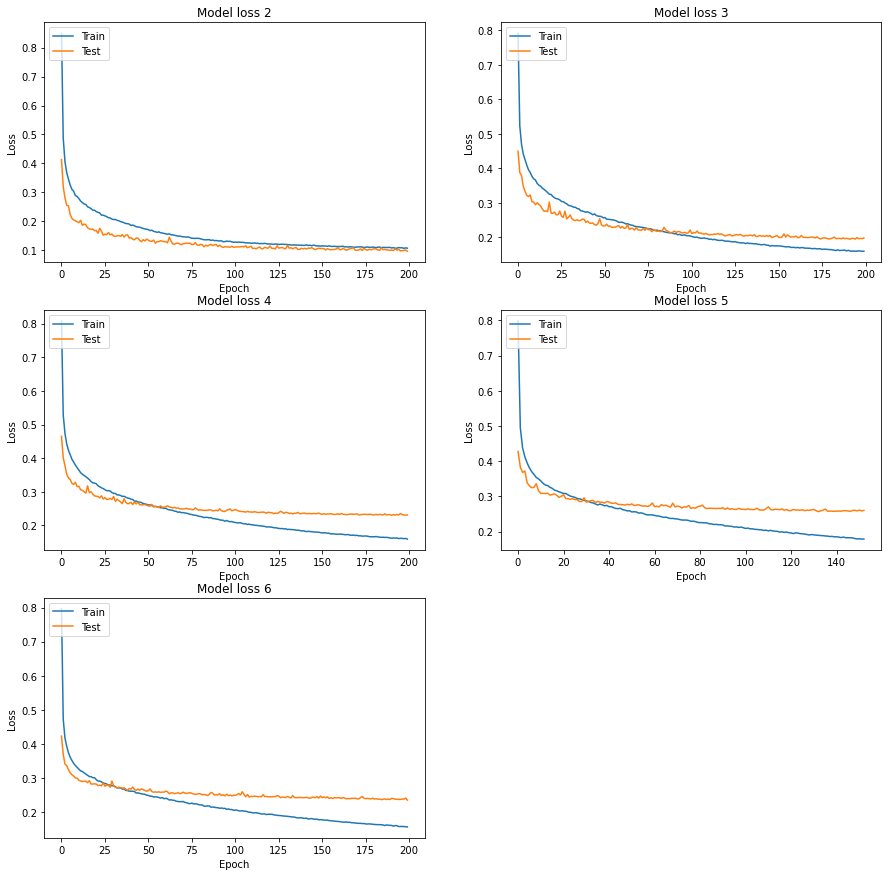

In [19]:
fig = plt.figure(figsize = (15, 15))
for i in range(5):
    fig.add_subplot(3, 2, i+1)
    plt.plot(history[i+2].history['loss'])
    plt.plot(history[i+2].history['val_loss'])
    plt.title('Model loss '+str(i+2))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

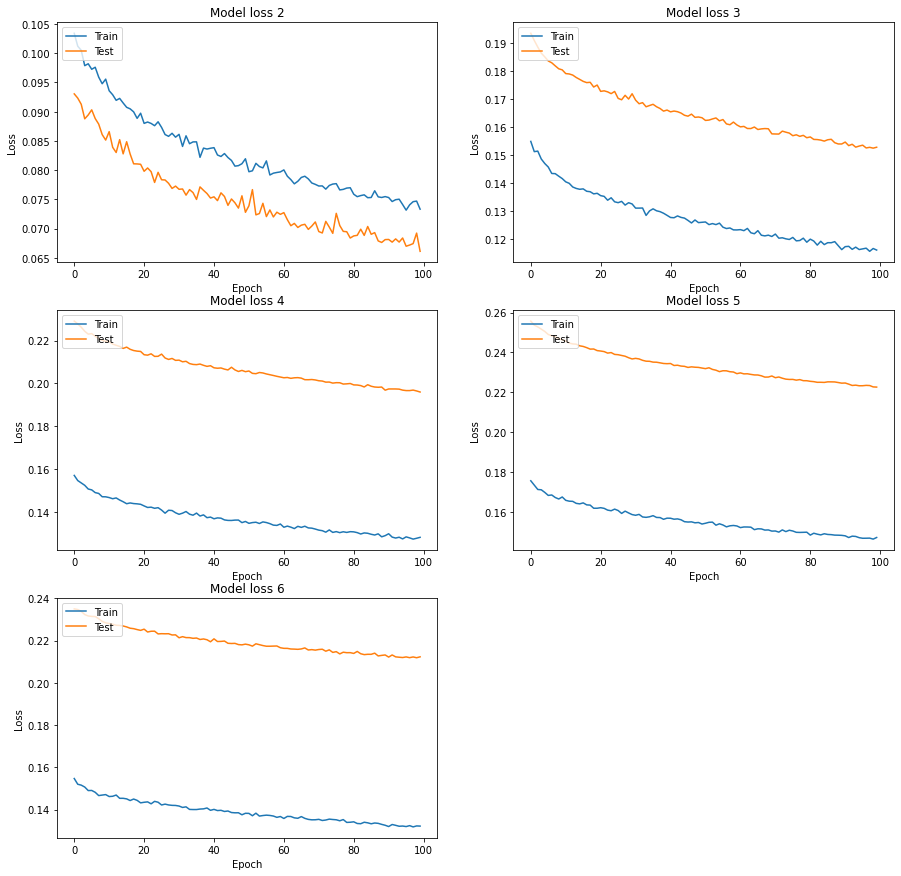

In [20]:
fig = plt.figure(figsize = (15, 15))
for i in range(5):
    fig.add_subplot(3, 2, i+1)
    plt.plot(history_ft[i+2].history['loss'])
    plt.plot(history_ft[i+2].history['val_loss'])
    plt.title('Model loss '+str(i+2))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')